In [125]:
import sys
sys.path.append('./../prepping/')

import numpy as np
import pandas as pd

from scipy import linalg
from scipy.spatial import distance

from transforms import Whitening

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [126]:
X = pd.read_csv('./../../../data_source/to_analysis/no_filter_concat.csv',index_col=0)
X.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,...,PET_original_gldm_SmallDependenceHighGrayLevelEmphasis.2,PET_original_gldm_SmallDependenceLowGrayLevelEmphasis.2,PET_original_ngtdm_Busyness.2,PET_original_ngtdm_Coarseness.2,PET_original_ngtdm_Complexity.2,PET_original_ngtdm_Contrast.2,PET_original_ngtdm_Strength.2,SUVpeak,MTV,TLG
patient,,,,,,,,,,,,,,,,,,,,,
2,0.738882,0.723925,27.060529,37.380273,41.976184,44.598206,42.720019,45.617979,27.619612,0.661532,...,43.463833,0.000628,1.154403,0.000825,269.014757,0.118665,1.541690,21.616549,7.384,124.870726
4,0.796900,0.629917,19.845151,31.504408,38.587563,35.468296,29.410882,38.704005,25.105855,0.701721,...,51.943196,0.000634,0.685552,0.001717,312.311426,0.146972,2.658648,15.296275,3.406,41.554406
5,0.600926,0.535140,22.515072,42.073251,46.065171,43.011626,32.015621,46.454279,25.282894,0.762365,...,44.989181,0.000535,0.956497,0.000878,260.071046,0.100053,1.755065,14.473272,7.934,86.228420
8,0.784571,0.414247,30.263897,73.057649,74.148500,80.956779,65.764732,83.438600,57.318945,0.520001,...,40.436803,0.000370,2.913565,0.000506,239.436835,0.096156,0.432808,10.510859,26.926,205.413389
10,0.690320,0.539743,19.449801,36.035312,33.286634,38.013156,33.015148,43.150898,24.875896,0.643822,...,49.151806,0.000605,0.521241,0.002781,290.056759,0.095754,1.835505,7.213190,6.041,32.103770


## t-Distributed Stochastic Neighbor Embedding

In [127]:
# NOTE: Use PCA-cor when maximal compression is desirable.
pca_cor = Whitening(method='pca_cor')
Z = pca_cor.fit_transform(X.values)

In [128]:
X.shape

(198, 607)

In [43]:
def similarity_matrix(X):
    """"""

    S = distance.squareform(distance.pdist(X))
    return -S / np.max(S)


def centering_matrix(nrows):
    """"""

    scaled = (np.ones((1, nrows)) / nrows)
    H = np.eye(nrows) - np.ones((nrows, 1)) * scaled
    # Experimental version where H := H / (n - 1).
    return H / (nrows - 1)

def solve_l20(Q, nfeats):

    # b(i) is the (l2-norm)^2 of the i-th row of Q.
    b = np.sum(Q ** 2, axis=1)[:, np.newaxis]
    idx = np.argsort(b[:, 0])[::-1]

    P = np.zeros(np.shape(Q), dtype=float)
    P[idx[:nfeats], :] = Q[idx[:nfeats], :]

    return P

def speed_up(C):
    """Refer to Simultaneous Clustering and Model Selection (SCAMS),
    CVPR2014.

    """
    diagmask = np.eye(np.shape(C)[0], dtype=bool)
    # Main diagonal = 0.
    C[diagmask] = 0

    # If C is (N x N), then tmp is (N*N x 1).
    tmp = np.reshape(C, (np.size(C), 1))
    # Remove the main diagonal elements of C in tmp. Then tmp has a
    # length of N * (N - 1).
    tmp = np.delete(tmp, np.where(diagmask.ravel()))
    # Scale to [0, 1] range.
    tmp = (tmp - np.min(tmp)) / (np.max(tmp) - np.min(tmp))

    affmaxo = C
    # affmaxo(~diagmask) is a column vector.
    affmaxo[np.logical_not(diagmask)] = tmp
    C_new = affmaxo

    return C_new


def solve_rank_lagrange(A, eta):
    """"""

    # Guarantee symmetry.
    A = 0.5 * (A + np.transpose(A))
    tempD, tempV = linalg.eig(A)
    # Discard the imaginary part.
    tempV = np.real(tempV)
    tmpD = np.real(tempD)

    tempD = np.real(np.diag(tempD))
    # eta * rank(P)
    tmpD[tmpD <= np.sqrt(eta)] = 0
    tempD = np.diag(tmpD)

    P = tempV.dot(tempD).dot(np.transpose(tempV))

    return P


def solve_l0_binary(Q, gamma):
    """"""

    P = np.copy(Q)
    # Each P_ij is in {0, 1}
    if gamma > 1:
        P[Q > 0.5 * (gamma + 1)] = 1
        P[Q <= 0.5 * (gamma + 1)] = 0
    else:
        P[Q > 1] = 1
        P[Q < np.sqrt(gamma)] = 0

    return P


def best_map(L1, L2):
    """Permute labels of L2 match L1 as good as possible.

    """

    if np.size(L1) != np.size(L2):
        raise RuntimeError('Got sizes L1: {} and L2 {}, when should be equal'
                           ''.format(np.size(L1), np.size(L2)))

    Label1 = np.unique(L1); nClass1 = len(Label1)
    Label2 = np.unique(L2); nClass2 = len(Label2)

    nClass = max(nClass1,nClass2)
    G = zeros(nClass)
    for i in range(nClass1):
        for j in range(nClass2):
            G[i, j] = len(np.where(L1 == Label1[i] and L2 == Label2[j]))

    c, t = linear_sum_assignment(-1.0 * G);

    newL2 = np.zeros(np.size(L2))
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]

    return newL2

In [44]:
class DGUFS(BaseEstimator, TransformerMixin):
    """The Dependence Guided Unsupervised Feature Selection (DGUFS) algorithm
    developed by Jun Guo and Wenwu Zhu.

    num_features (int): The number of features to select.
    num_clusters (int):
    alpha (): Regularization parameter from the range (0, 1).
    beta (): Regularization parameter > 0.
    tol (float): Tolerance used to determine optimization convergance. Defaults
        to 10e-6 as suggested in the paper.
    max_iter (): The maximum number of iterations of the
    mu ():
    max_mu ():
    rho ():

    """

    NAME = 'DGUFSSelection'

    def __init__(
        self,
        num_features=2,
        num_clusters=2,
        alpha=0.5,
        beta=0.9,
        tol=1e-6,
        max_iter=1e2,
        mu=1e-6,
        max_mu=1e10,
        rho=1.1
    ):

        self.num_features = num_features
        self.num_clusters = num_clusters
        self.alpha = alpha
        self.beta = beta
        self.tol = tol
        self.max_iter = max_iter
        self.mu = mu
        self.max_mu = max_mu
        self.rho = rho

        # NOTE: Attributes set with instance.
        self.S = None
        self.H = None
        self.Y = None
        self.Z = None
        self.M = None
        self.L = None
        self.V = None
        self.Lamda1 = None
        self.Lamda2 = None

    def _setup_matrices(self, nrows, ncols):
        # Setup.
        self.Y = np.zeros((ncols, nrows), dtype=float)
        self.Z = np.zeros((ncols, nrows), dtype=float)

        self.M = np.zeros((nrows, nrows), dtype=float)
        self.L = np.zeros((nrows, nrows), dtype=float)

        self.Lamda1 = np.zeros((ncols, nrows), dtype=float)
        self.Lamda2 = np.zeros((nrows, nrows), dtype=float)

        return self

    def __name__(self):

        return self.NAME

    def _check_X(self, X):
        # Type checking and formatting of feature matrix.
        nrows, ncols = np.shape(X)
        if self.num_features > ncols:
            raise ValueError('Number of features to select exceeds the number '
                             'of columns in X ({})'.format(ncols))
        if nrows < 2:
            raise RuntimeError('Feature selection requires more than two '
                               'samples')
        # NB: From nrows x ncols to ncols x nrows as algorithm given in the
        # paper.
        X_trans = np.transpose(X)

        return X_trans, nrows, ncols

    @property
    def support(self):
        """Returns the column indicators of selected features."""

        # Select features based on where the transformed feature matrix has
        # column sums != 0.
        selected_cols = np.squeeze(np.where(np.sum(self.Y.T, axis=0) != 0))
        # Sanity check.
        assert len(selected_cols) <= self.num_features

        return selected_cols

    @property
    def memberships(self):
        """Return the cluster indicator labels for each obeservation."""

        # NOTE: Alternatively use scipy.sparse.linalg.eigs with
        # k=self.num_clusters.
        eigD, eigV = linalg.eig(np.maximum(self.L, np.transpose(self.L)))
        # Discard imaginary parts and truncate assuming comps are sorted.
        eigD = np.real(np.diag(eigD)[:self.num_clusters, :self.num_clusters])
        eigV = np.real(eigV[:, :self.num_clusters])
        self.V = np.dot(eigV, np.sqrt(eigD))
        # The final cluster labels can be obtained by determining the position
        # of the largest element at each cluster indicator in V.
        return np.argmax(self.V, axis=1)

    def fit(self, X, **kwargs):
        """Select features from X.

        Args:
            X (array-like): The feature matrix with shape
                (n samples x n features).

        """
        X_trans, nrows, ncols = self._check_X(X)

        self.S = similarity_matrix(X)
        # Experimental version where H := H / (n - 1).
        self.H = centering_matrix(nrows)

        self._setup_matrices(nrows, ncols)

        i = 1
        while i <= self.max_iter:

            # Alternate optimization of matrices.
            self._update_Z(X_trans, ncols)
            self._update_Y()
            self._update_L()
            self._update_M(nrows)

            # Check if stop criterion is satisfied.
            leq1 = self.Z - self.Y
            leq2 = self.L - self.M
            stopC1 = np.max(np.abs(leq1))
            stopC2 = np.max(np.abs(leq2))
            if (stopC1 < self.tol) and (stopC2 < self.tol):
                i = self.max_iter
            else:
                # Update Lagrange multipliers.
                self.Lamda1 = self.Lamda1 + self.mu * leq1
                self.Lamda2 = self.Lamda2 + self.mu * leq2
                self.mu = min(self.max_mu, self.mu * self.rho);
                # Update counter.
                i = i + 1

        return self

    def _update_Z(self, X, ncols):
        # Updates the Z matrix.
        YHLH = self.Y.dot(self.H).dot(self.L).dot(self.H)
        U = X - self.Y - (((1 - self.beta) * YHLH - self.Lamda1) / self.mu)
        self.Z = X - solve_l20(U, (ncols - self.num_features))

        return self

    def _update_Y(self):
        # Updates the Y matrix.
        ZHLH = self.Z.dot(self.H).dot(self.L).dot(self.H)
        U = self.Z + (((1 - self.beta) * ZHLH + self.Lamda1) / self.mu)
        self.Y = solve_l20(U, self.num_features)

        return self

    def _update_L(self):
        # Updates the L matrix.
        _speed_up = speed_up(
            self.H.dot(np.transpose(self.Y)).dot(self.Z).dot(self.H)
        )
        U = ((1 - self.beta) * _speed_up + self.beta * self.S - self.Lamda2)
        self.L = solve_rank_lagrange(
            speed_up(U / self.mu + self.M), 2 * self.alpha / self.mu
        )
        return self

    def _update_M(self, nrows, gamma=5e-3):
        # Updates the M matrix.
        _M = self.L + self.Lamda2 / self.mu
        _M = solve_l0_binary(_M, 2 * gamma / self.mu)

        self.M = _M - np.diag(np.diag(_M)) + np.eye(nrows)

        return self

    def transform(self, X, **kwargs):
        """Retain selected features from X.

        Args:
            X (array-like): The feature matrix with shape
                (n samples x n features).

        Returns:
            (array-like): The feature matrix containing only the selected
                features.

        """

        if isinstance(X, pd.DataFrame):
            data = X.values
            output = pd.DataFrame(
                data[:, self.support],
                columns=X.columns[self.support],
                index=X.index
            )
        elif isinstance(X, np.ndarray):
            output = X[:, self.support]
        else:
            raise TypeError('Cannot transform data of type {}'.format(type(X)))

        return output

# Radiomics Feature Exploration

In [105]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [22]:
# Globals
SEED = 0

In [62]:
dfs = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)
lrr = pd.read_csv('./../../../data_source/to_analysis/target_lrr.csv', index_col=0)

y = np.squeeze(dfs.values)


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,...,PET_original_gldm_SmallDependenceHighGrayLevelEmphasis.2,PET_original_gldm_SmallDependenceLowGrayLevelEmphasis.2,PET_original_ngtdm_Busyness.2,PET_original_ngtdm_Coarseness.2,PET_original_ngtdm_Complexity.2,PET_original_ngtdm_Contrast.2,PET_original_ngtdm_Strength.2,SUVpeak,MTV,TLG
patient,,,,,,,,,,,,,,,,,,,,,
2,0.738882,0.723925,27.060529,37.380273,41.976184,44.598206,42.720019,45.617979,27.619612,0.661532,...,43.463833,0.000628,1.154403,0.000825,269.014757,0.118665,1.541690,21.616549,7.384,124.870726
4,0.796900,0.629917,19.845151,31.504408,38.587563,35.468296,29.410882,38.704005,25.105855,0.701721,...,51.943196,0.000634,0.685552,0.001717,312.311426,0.146972,2.658648,15.296275,3.406,41.554406
5,0.600926,0.535140,22.515072,42.073251,46.065171,43.011626,32.015621,46.454279,25.282894,0.762365,...,44.989181,0.000535,0.956497,0.000878,260.071046,0.100053,1.755065,14.473272,7.934,86.228420
8,0.784571,0.414247,30.263897,73.057649,74.148500,80.956779,65.764732,83.438600,57.318945,0.520001,...,40.436803,0.000370,2.913565,0.000506,239.436835,0.096156,0.432808,10.510859,26.926,205.413389
10,0.690320,0.539743,19.449801,36.035312,33.286634,38.013156,33.015148,43.150898,24.875896,0.643822,...,49.151806,0.000605,0.521241,0.002781,290.056759,0.095754,1.835505,7.213190,6.041,32.103770


In [25]:
X.shape

(198, 607)

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X[:3, :4]

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 0.29960126,  1.6782484 ,  0.45991405, -0.4331427 ],
       [ 0.69450401,  0.91446611, -0.29310883, -0.7977153 ],
       [-0.63941091,  0.14444325, -0.01446627, -0.1419633 ]])

## t-distributed Stochastic Neighbor Embedding

In [116]:
transf = Whitening()
Z = transf.fit_transform(X)
Z[:4, :4]

array([[-0.13522262,  3.14143072,  0.67159361,  0.65274713],
       [-0.0399836 ,  1.37347754, -0.6393336 , -0.54418994],
       [-0.57784301, -0.51750898, -0.0357379 ,  1.79126997],
       [ 0.17411751, -0.60940729, -2.37625321,  0.21030865]])

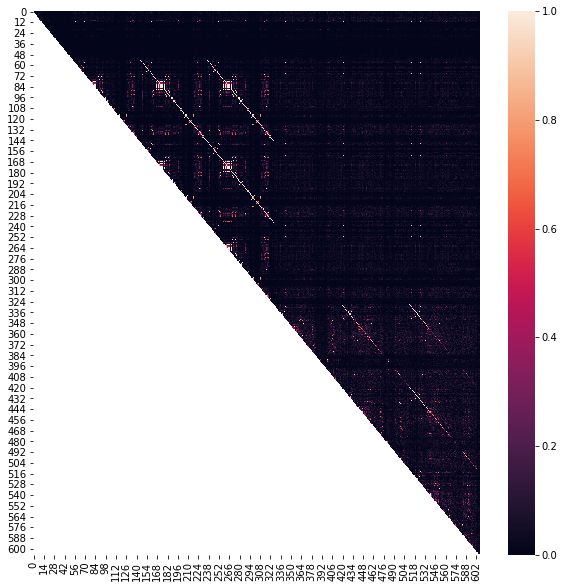

In [121]:
Z_df = pd.DataFrame(Z)
corr_mat = Z_df.corr().abs()

upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

plt.figure(figsize=(10, 10))
sns.heatmap(upper)

In [122]:
pca_corr = Whitening(method='pca_cor')
Z_pca_corr = pca_corr.fit_transform(X)
Z_pca_corr[:5, :5]

array([[-0.55718117, -0.13850671,  0.09757432, -1.00863877, -0.67301402],
       [ 1.38917618, -1.13374504,  0.46578432,  0.89607379, -0.34457682],
       [ 0.09977715,  0.13041231,  0.77487696,  0.03671521,  0.11672354],
       [-0.53878002, -1.51135661, -0.05490931,  0.44599188,  0.35457686],
       [ 0.10280956, -0.89375178, -0.67938954, -1.03984932, -2.31498615]])

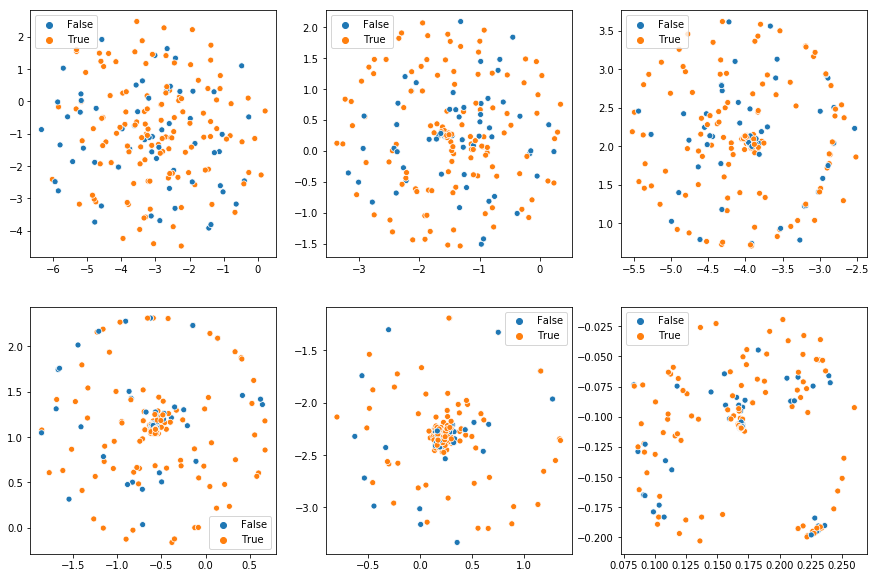

In [123]:
# TODOS:
# * Possible to run SMAC optimization wrt. KL-divergence of t-SNE algorithm for parameter tuning?
# * Theoretically how to decompose ZCA-cor into extract number of components (look to PCA and retaining of 
#   eigenvalues).
# * Replace PCA recommendation in t-SNE with ZCA-cor as recommended to preserve interpretability of original 
#   features. Perform t-SNE visualization and include in thesis along with method theory.

# NOTE:
# * Make sure the same scale is used over all features. Because manifold learning methods are based on a 
#   nearest-neighbor search, the algorithm may perform poorly otherwise. See StandardScaler for convenient 
#   ways of scaling heterogeneous data.
# * Note that noisy data can “short-circuit” the manifold, in essence acting as a bridge between parts of the 
#   manifold that would otherwise be well-separated.
# * Highly recommended to use another dimensionality reduction method to reduce the number of dimensions to a 
#   reasonable amount if the number of features is very high. 
# * Perplexity: how to balance attention between local and global aspects of your data
#   (a guess about the number of close neighbors each point has).
# * Perplexity values in the range (5 - 50) suggested by van der Maaten & Hinton. With perplexity 2, 
#   local variations dominate.
# * For the algorithm to operate properly, the perplexity really should be smaller than the number 
#   of points.
# * The most important thing is to iterate until reaching a stable configuration (selecting suffieciently 
#   large number of iters). Different data sets can require different numbers of iterations to converge.
# * You cannot see relative sizes of clusters in a t-SNE plot. 
# * Distances between well-separated clusters in a t-SNE plot may mean nothing.


# t-SNE hparam space: use log for testing a wider range of preplexity and learning rate values.
# Let num iter be large > 5000 and num comps = 2 (for visualzation).

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

perplexities = [2, 10, 20]
for num, perplexity in enumerate(perplexities):
    embedder = TSNE(
        n_components=2, 
        random_state=0, 
        learning_rate=80,
        perplexity=perplexity,
        n_iter=5000,
    )
    Z_embedded = embedder.fit_transform(Z_pca_corr)
    sns.scatterplot(
        Z_embedded[:, 0], 
        Z_embedded[:, 1], 
        hue=y==0,
        ax=axes[0, num]
    )

perplexities = [35, 50, 80]
for num, perplexity in enumerate(perplexities):
    embedder = TSNE(
        n_components=2, 
        random_state=0, 
        learning_rate=80,
        perplexity=perplexity,
        n_iter=5000,
    )
    Z_embedded = embedder.fit_transform(Z_pca_corr)
    sns.scatterplot(
        Z_embedded[:, 0], 
        Z_embedded[:, 1], 
        hue=y==0,
        ax=axes[1, num]
    )

#plt.tight_layout()

In [ ]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py

## Dependence Guided Unsupervised Feature Selection

In [10]:
#from dgufs.dgufs import DGUFS

from sklearn.metrics import normalized_mutual_info_score

# Import ConfigSpace and different types of parameters.
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter
from ConfigSpace.hyperparameters import UniformFloatHyperparameter
from ConfigSpace.hyperparameters import UniformIntegerHyperparameter

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.facade.smac_facade import SMAC

In [12]:
hparams = (
    UniformIntegerHyperparameter(lower=2, upper=600, default=2),
    UniformIntegerHyperparameter(lower=1, upper=600, default=2),
    UniformFloatHyperparameter(lower=1e-6, upper=1-1e-6, default=0.5),
    UniformFloatHyperparameter(lower=1e-6, upper=20, default=0.9)
)
config = ConfigurationSpace()
config.seed(SEED)
config.add_hyperparameters(hparams)



In [ ]:
def objective(hparams):
    """Determine the optimal hyperparameter settings for
    the DGUFS algorithm with respect to normalized MI.
    
    """
    
    global X, y
    
    model = DGUFS(**hparams)
    model.fit(X)
    
    y_pred = model.
    y_true = np.squeeze(y_dfs.values)
    #y_true = np.squeeze(y_lrr.values)
    
    return normalized_mutual_info_score(y_true, y_pred, average_method='geometric')

In [39]:
model = DGUFS(num_clusters=100, num_features=600)
model.fit(X)

DGUFS(alpha=0.5, beta=0.9, max_iter=100.0, max_mu=10000000000.0,
   mu=0.013780612339822387, num_clusters=100, num_features=600, rho=1.1,
   tol=1e-06)

In [40]:
model.memberships

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:108: RuntimeWarning: invalid value encountered in sqrt


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Affinity propagation clustering algorithm

In [ ]:
from sklearn import metrics
from sklearn.cluster import AffinityPropagation

In [ ]:
labels_true = np.squeeze(dfs.values)
#labels_true = np.squeeze(lrr.values)

# Compute Affinity Propagation
af = AffinityPropagation().fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))

from itertools import cycle

plt.close('all')
plt.figure(figsize=(12, 8))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X.values[cluster_centers_indices[k]]
    plt.plot(X.values[class_members, 0], X.values[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X.values[class_members, :]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)

## Agglomerative Clustering

In [ ]:
from time import time

from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering

# Good clustering = separate numbers in each color group.

In [ ]:
y = np.squeeze(dfs.values)
#y = np.squeeze(lrr.values)


def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    

print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [ ]:
# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward',
                                         'single')):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time()
            model.fit(X)
            elapsed_time = time() - t0
            plt.scatter(X.values[:, 0], X.values[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X.values[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X.values[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)